# Video classification with Keras and Deep Learning
#THIS USES ALL 22 SPORTS IN THE DATASET (INITIAL VERSION USED 3)

https://www.pyimagesearch.com/2019/07/15/video-classification-with-keras-and-deep-learning/

Video classification with Keras and Deep Learning
by Adrian Rosebrock on July 15, 2019 in Deep Learning, Keras, Tutorials
 Python File Icon Click here to download the source code to this post
 










In this tutorial, you will learn how to perform video classification using Keras, Python, and Deep Learning.

Specifically, you will learn:

The difference between video classification and standard image classification
How to train a Convolutional Neural Network using Keras for image classification
How to take that CNN and then use it for video classification
How to use rolling prediction averaging to reduce “flickering” in results
This tutorial will serve as an introduction to the concept of working with deep learning in a temporal nature, paving the way for when we discuss Long Short-term Memory networks (LSTMs) and eventually human activity recognition.


When performing image classification, we:

Input an image to our CNN
Obtain the predictions from the CNN
Choose the label with the largest corresponding probability
Since a video is just a series of frames, a naive video classification method would be to:

Loop over all frames in the video file
For each frame, pass the frame through the CNN
Classify each frame individually and independently of each other
Choose the label with the largest corresponding probability
Label the frame and write the output frame to disk
There’s a problem with this approach though — if you’ve ever tried to apply simple image classification to video classification you likely encountered a sort of “prediction flickering” as seen in the video at the top of this section. Notice how in this visualization we see our CNN shifting between two predictions: “football” and the correct label, “weight_lifting”.

The video is clearly of weightlifting and we would like our entire video to be labeled as such — but how we can prevent the CNN “flickering” between these two labels?

A simple, yet elegant solution, is to utilize a rolling prediction average.

Our algorithm now becomes:

Loop over all frames in the video file
For each frame, pass the frame through the CNN
Obtain the predictions from the CNN
Maintain a list of the last K predictions
Compute the average of the last K predictions and choose the label with the largest corresponding probability
Label the frame and write the output frame to disk
The results of this algorithm can be seen in the video at the very top of this post — notice how the prediction flickering is gone and the entire video clip is correctly labeled!

In the remainder of this tutorial, you will learn how to implement this algorithm for video classification with Keras.

# Furthermore, our training script will train on ALL 22 sports

---



#The Sports Classification Dataset

See colab data Sports-Type-Classifier folder

copied from github

unzip keras-video-classification.zip
$ cd keras-video-classification

	
$ git clone https://github.com/anubhavmaity/Sports-Type-Classifier

$ ls Sports-Type-Classifier/data | grep -Ev "urls|models|csv|pkl"

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:

# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() #LOOK FOR 0% IN LAST LINE
#!kill -9 -1

Gen RAM Free: 26.4 GB  | Proc size: 152.1 MB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB


In [3]:
#note this is the directory structure on my macbook

tree --dirsfirst --filelimit 50
.
├── Sports-Type-Classifier
│   ├── data
│   │   ├── badminton [938 entries]
│   │   ├── baseball [746 entries]
│   │   ├── basketball [495 entries]
│   │   ├── boxing [705 entries]
│   │   ├── chess [481 entries]
│   │   ├── cricket [715 entries]
│   │   ├── fencing [635 entries]
│   │   ├── football [799 entries]
│   │   ├── formula1 [687 entries]
│   │   ├── gymnastics [719 entries]
│   │   ├── hockey [572 entries]
│   │   ├── ice_hockey [715 entries]
│   │   ├── kabaddi [454 entries]
│   │   ├── motogp [679 entries]
│   │   ├── shooting [536 entries]
│   │   ├── swimming [689 entries]
│   │   ├── table_tennis [713 entries]
│   │   ├── tennis [718 entries]
│   │   ├── volleyball [713 entries]
│   │   ├── weight_lifting [577 entries]
│   │   ├── wrestling [611 entries]
│   │   ├── wwe [671 entries]
|   ...
├── example_clips
│   ├── lifting.mp4
│   ├── soccer.mp4
│   └── tennis.mp4
├── model
│   ├── activity.model
│   └── lb.pickle
├── output
├── plot.png
├── predict_video.py
└── train.py
 

SyntaxError: ignored

In [6]:
import os
os.listdir()
from google.colab import  drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
os.listdir()
data_dir='/content/drive/My Drive/Colab Notebooks/data/Sports-Type-Classifier/data/'
proj_dir= '/content/drive/My Drive/Colab Notebooks/pyimage-sports-video-classifier/'


In [6]:
os.listdir(proj_dir)

['pyimage-sports-video-classifier-dataset.ipynb',
 'readme.txt',
 'model',
 'output',
 'examples',
 'sports-video-classification.png',
 'loss_acc.png',
 'trained_model_5epochs.pickle',
 'trained_model_weights_5epochs.h5',
 'model_architecture_5epochs.json',
 'pyimage-sports-video-classifier.ipynb',
 'trained_model_22sports_5epochs.pickle',
 'pyimage-sports22-video-classifier.ipynb']

In [8]:
os.listdir(data_dir)

['badminton',
 'baseball',
 'basketball',
 'football',
 'tennis',
 'weight_lifting',
 'formula1',
 'cricket',
 'motogp',
 'chess',
 'swimming',
 'hockey',
 'gymnastics',
 'shooting',
 'fencing',
 'kabaddi',
 'volleyball',
 'ice_hockey',
 'table_tennis',
 'wrestling',
 'wwe',
 'boxing']

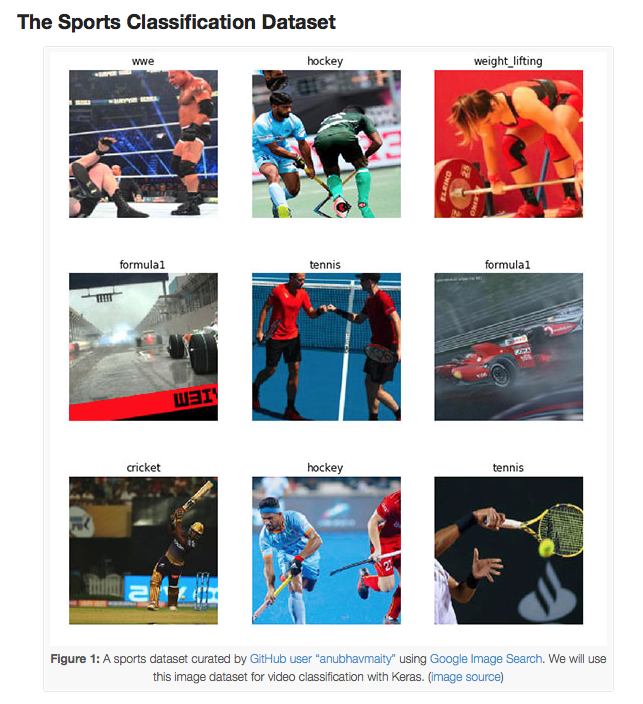

In [8]:
os.chdir(proj_dir)
from IPython.display import Image
Image('./sports-video-classification.png')

In [9]:
import keras
print('keras version ', keras.__version__)
#I have keras 2.1.3 on my macbook
import tensorflow as tf
print('tensorflow version ', tf.__version__)
#i have version 1.1.0 on my macbook

keras version  2.2.4
tensorflow version  1.14.0


Using TensorFlow backend.


In [9]:
import matplotlib
matplotlib.use('Agg')

#import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.pooling import AveragePooling2D
from keras.applications import ResNet50
from keras.layers.core import Dropout, Flatten, Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
#import argparse
import pickle
import cv2
import os

Using TensorFlow backend.


In [10]:
#initialise labels
LABELS = set(['badminton', 'baseball', 'basketball', 'boxing', 'chess','cricket',
              'fencing','football','formula1', 'gymnastics', 'hockey', 'ice_hockey',
              'kabaddi', 'moto_gp', 'shooting', 'swimming', 'table_tennis',
              'tennis', 'volleyball', 'weight_lifting', 'wrestling','wwe'])
print(len(LABELS) , ' sports')

22  sports


In [11]:
print('[INFO] loading images...')
imagePaths = list(paths.list_images(data_dir))
#14429 images total for 22 sports
print(len(imagePaths))

[INFO] loading images...
14429


In [0]:
data=[]
labels=[]

In [0]:
for imagePath in imagePaths:
  #extract class label
  label = imagePath.split(os.path.sep)[-2]
  
  if label not in LABELS:
    continue
  
  #process image
  image = cv2.imread(imagePath)
  image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image= cv2.resize(image,(224,224))
  
  data.append(image)
  labels.append(label)
  
#convert to array
data=np.array(data)
labels=np.array(labels)

#one-hot encode
lb= LabelBinarizer()
labels=lb.fit_transform(labels)

#train test split
(trainX, testX, trainY, testY)= train_test_split(data, labels,
                                                 test_size=0.25,
                                                stratify=labels,
                                                random_state=42)


In [0]:
#quick save
f=open(proj_dir + 'trained_model_22sports_5epochs.pickle','wb')
f.write(pickle.dumps(lb))
f.close()

In [0]:
#initialise training data augmentation
trainAug=ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest')

#initialise val/test data aug (which we'll be adding mean subtraction to)
valAug=ImageDataGenerator()

#define ImageNet mean subtraction in RGB order
mean=np.array([123.68,116.779, 103.939], dtype='float32')
trainAug.mean=mean
valAug.mean=mean

In [16]:
#load ResNet-50 set head FC layers to off
baseModel=ResNet50(weights='imagenet', include_top=False,
                  input_tensor=Input(shape=(224,224,3)))


W0729 10:15:27.047407 140110248187776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0729 10:15:27.061391 140110248187776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0729 10:15:27.066945 140110248187776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0729 10:15:27.090387 140110248187776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0729 10:15:27.091518

In [17]:
base=baseModel.output
base.shape

TensorShape([Dimension(None), Dimension(7), Dimension(7), Dimension(2048)])

In [18]:
#construct head of model to be placed on base
headModel=baseModel.output
headModel=AveragePooling2D(pool_size=(7,7))(headModel)
headModel=Flatten(name='flatten')(headModel)
headModel=Dense(512, activation='relu')(headModel)
headModel=Dropout(0.5)(headModel)
headModel=Dense(len(lb.classes_), activation='softmax')(headModel)

W0729 10:15:39.277056 140110248187776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W0729 10:15:39.305643 140110248187776 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
#place head on base
model=Model(inputs=baseModel.input, outputs=headModel)

In [0]:
#loop over all layers i nbase model and freeze them so not updated
#during training process
for layer in baseModel.layers:
  layer.trainable=False

In [21]:
#compile
print('[INFO] compiling model...')
N = 50
#opt=SGD(lr=1e-4, momentum=0.9, decay=1e-4/args['epochs'])
opt=SGD(lr=1e-4, momentum=0.9, decay=1e-4/N)
model.compile(loss='categorical_crossentropy',
             optimizer=opt,
             metrics=['accuracy'])


W0729 10:15:44.423225 140110248187776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



[INFO] compiling model...


In [22]:
#train head of network with few epochs
#allows new FC layers to start to become intialised with actual 'learned'
#values vs pure random

print('[INFO] training head...')
H=model.fit_generator(trainAug.flow(trainX, trainY, batch_size=32),
                     steps_per_epoch=len(trainX)//32,
                     validation_data=valAug.flow(testX, testY),
                     validation_steps=len(testX)//32,
                     #epochs=args['epochs'])
                     epochs=N)

[INFO] training head...


W0729 10:15:52.375619 140110248187776 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
322/322 [==============================] - 107s 334ms/step - loss: 3.2163 - acc: 0.0824 - val_loss: 2.8157 - val_acc: 0.1790
Epoch 2/50
322/322 [==============================] - 103s 321ms/step - loss: 2.7633 - acc: 0.1884 - val_loss: 2.4861 - val_acc: 0.2674
Epoch 3/50
322/322 [==============================] - 103s 320ms/step - loss: 2.4930 - acc: 0.2783 - val_loss: 2.2298 - val_acc: 0.3428
Epoch 4/50
322/322 [==============================] - 102s 318ms/step - loss: 2.2879 - acc: 0.3465 - val_loss: 2.0538 - val_acc: 0.4006
Epoch 5/50
322/322 [==============================] - 103s 319ms/step - loss: 2.1139 - acc: 0.3914 - val_loss: 1.9010 - val_acc: 0.4403
Epoch 6/50
322/322 [==============================] - 103s 319ms/step - loss: 1.9776 - acc: 0.4346 - val_loss: 1.7714 - val_acc: 0.4825
Epoch 7/50
322/322 [==============================] - 103s 319ms/step - loss: 1.8610 - acc: 0.4632 - val_loss: 1.6730 - val_acc: 0.5054
Epoch 8/50
322/322 [============================

In [23]:
#evaluate
print('[INFO] evaluating network...')
predictions=model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1), 
                            predictions.argmax(axis=1),
                            target_names=lb.classes_))

[INFO] evaluating network...
                precision    recall  f1-score   support

     badminton       0.44      0.84      0.58       232
      baseball       0.71      0.63      0.66       183
    basketball       0.41      0.80      0.54       122
        boxing       0.79      0.62      0.70       176
         chess       0.91      0.72      0.81       119
       cricket       0.84      0.55      0.67       166
       fencing       0.65      0.53      0.58       156
      football       0.52      0.87      0.65       196
      formula1       0.89      0.82      0.85       169
    gymnastics       0.75      0.57      0.65       178
        hockey       0.64      0.53      0.58       142
    ice_hockey       0.80      0.85      0.83       177
       kabaddi       0.57      0.88      0.69       113
      shooting       0.97      0.61      0.75       140
      swimming       0.99      0.58      0.74       171
  table_tennis       0.91      0.57      0.70       184
        tennis    

In [0]:
#plot training loss and accuracy

#N=args['epochs']
N=50

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0,N),H.history['loss'], label='train_loss')
plt.plot(np.arange(0,N),H.history['val_loss'], label='val_loss')
plt.plot(np.arange(0,N),H.history['acc'], label='train_acc')
plt.plot(np.arange(0,N),H.history['val_acc'], label='val_acc')
plt.title('Training Loss and Accuracy on Dataset')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend(loc='lower left')
plt.savefig(proj_dir + 'loss_acc_22sports_50epochs.png')


/content/drive/My Drive/Colab Notebooks/pyimage-sports-video-classifier


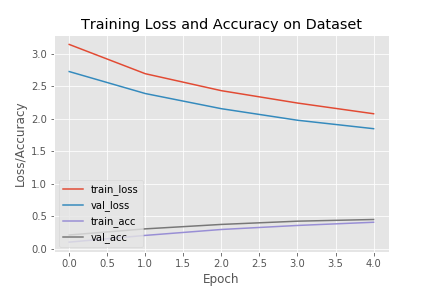

In [35]:
!pwd
from IPython.display import Image
Image('./loss_acc_22sports_50epochs.png')

In [26]:
#serialise model to disk
print('[INFO] serialising network...')
#model.save(args['model'])
'save entire model - arch + weights'
model.save(proj_dir + 'model/trained_model_22sports_50epochs.model')

#https://jovianlin.io/saving-loading-keras-models/ recommends not using pickle
#to save keras models

#serialise label binarizer to disk
#f=open(args['label-bin'],'wb')
f=open(proj_dir + 'trained_model_22sports_50epochs.pickle','wb')
f.write(pickle.dumps(lb))
f.close()

[INFO] serialising network...


In [0]:
#This single HDF5 file will contain:
#the architecture of the model (allowing the recreation of the model)
#the weights of the model
#the training configuration (e.g. loss, optimizer)
#the state of the optimizer (allows you to resume the training from exactly where you left off)
#should be same as the .model file above

model.save('trained_model_arch_wts_22sports_50epochs.h5')

In [0]:
#only weights
model.save_weights(proj_dir + 'trained_model_weights_22_sports_50epochs.h5')

In [0]:
#save only architecture
arch = proj_dir + 'model_arch_22sports.json'
arch = model.to_json()

In [0]:
with open('model_architecture_50epochs.json', 'w') as f:
    f.write(model.to_json())

In [0]:
# Model reconstruction from JSON file
with open('model_architecture_5epochs.json', 'r') as f:
    loaded_model = model_from_json(f.read())


In [0]:
loaded_model.load_weights('trained_model_weights_5epochs.h5')

In [0]:
#aim is to evaluate with laoded model and see if we get same results
#evaluate
print('[INFO] evaluating loaded network...')
predictions_with_loaded_model =loaded_model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1), 
                            predictions.argmax(axis=1),
                            target_names=lb.classes_))

[INFO] evaluating loaded network...
                precision    recall  f1-score   support

      football       0.96      0.95      0.95       196
      formula1       0.97      0.91      0.94       169
        tennis       0.94      0.92      0.93       179
weight_lifting       0.87      0.97      0.92       143

      accuracy                           0.94       687
     macro avg       0.94      0.94      0.94       687
  weighted avg       0.94      0.94      0.94       687



# RELOAD SAVED TRAINED MODEL AND CONTINUE WITH PREDICTION

Video classification with Keras and rolling prediction averaging

We are now ready to implement video classification with Keras via rolling prediction accuracy!

To create this script we’ll take advantage of the temporal nature of videos, specifically the assumption that subsequent frames in a video will have similar semantic contents.

By performing rolling prediction accuracy we’ll be able to “smoothen out” the predictions and avoid “prediction flickering”.

The python script uses args as follows
$ python predict_video.py --model model/activity.model \
	--label-bin model/lb.pickle \
	--input example_clips/tennis.mp4 \
	--output output/tennis_1frame.avi \
	--size 1


Then, Lines 10-21 parse five command line arguments, four of which are required:

--model : The path to the input model generated from our previous training step.
--label-bin : The path to the serialized pickle-format label binarizer generated by the previous script.
--input : A path to an input video for video classification.
--output : The path to our output video which will be saved to disk.
--size : The max size of the queue for rolling averaging ( 128  by default). For some of our example results later on, we’ll set the size to 1  so that no averaging is performed

In [0]:
#model reconstruction
print(proj_dir)
os.chdir(proj_dir)
from keras.models import model_from_json

with open('model_architecture_5epochs.json','r') as f:
  loaded_model=model_from_json(f.read())

loaded_model.load_weights('trained_model_weights_5epochs.h5')

/content/drive/My Drive/Colab Notebooks/pyimage-sports-video-classifier/


In [0]:
loaded_model.summary()

In [0]:
from collections import deque
#We’ll use a deque  to implement our rolling prediction averaging.
#Our deque, Q , is initialized with a maxlen  equal to the args["size"] value 
from google.colab.patches import cv2_imshow
import numpy as np
import pickle
import cv2

#model == loaded_model
label_bin =  proj_dir + 'trained_model_50epochs.pickle'
input= proj_dir + 'examples/tennis.mp4'
size=1
#output_file= proj_dir + 'output/tennis_1frame_50epochs.avi'
output_file= proj_dir + 'output/tennis_1frame_50_epochs_smoothened.avi'

In [40]:
print(output_file)

/content/drive/My Drive/Colab Notebooks/pyimage-sports-video-classifier/output/tennis_1frame_50_epochs_smoothened.avi


# Keras video classification results

In [41]:
#lb=pickle.loads(open(label_bin,'rb').read())

#intialise image mean for subtraction along with preds queue
mean=np.array([123.68,116.779,103.939][::1],dtype='float32')
size=1 #turns video classification into standard image classification
#size =128 #utilises prediction averaging algorithm
Q=deque(maxlen=size)

vs=cv2.VideoCapture(input)
writer=None
(W,H) = (None,None)

while True:
  #read next frame from file
  (grabbed, frame)=vs.read()
  
  #if frame was not grabbed then end of stream
  if not grabbed:
    break
    
  #if frame dims are empty, grab them
  if W is None or H is None:
    (H,W) = frame.shape[:2]
    
  #clone output frame, BGR to RGB, resize to 224,224 and mean subtract
  output = frame.copy()
  frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  frame=cv2.resize(frame,(224,224)).astype('float32')
  frame -= mean
  
  #make predictions on frame and update predictions q
  #preds = loaded_model.predict(np.expand_dims(frame, axis=0))[0]
  preds = model.predict(np.expand_dims(frame, axis=0))[0]
  Q.append(preds)
  
  #perform prediction averaging over current history of previous preds
  results = np.array(Q).mean(axis=0)
  i=np.argmax(results)
  label=lb.classes_[i]
  
  #draw activity on output frame
  text ='activity: {}'.format(label)
  cv2.putText(output, text, (35,50), cv2.FONT_HERSHEY_SIMPLEX,
             1.25, (0,255,0),5)
  
  #check if video writer is none
  if writer is None:
    #initialise
    print('intialising writer')
    fourcc=cv2.VideoWriter_fourcc(*'MJPG')
    video_size = (W,H)
    writer = cv2.VideoWriter(output_file,fourcc,30, video_size)
  
  #write output frame to disk
  writer.write(output)
  
  #show output image
  #cv2.imshow('Output',output) this is NOT for colab
  #cv2_imshow(output) hashed to speed things up but it works on colab
  key=cv2.waitKey(1) & 0xFF
  
  #if 'q' key was pressed, break from loop
  if key==ord('q'):
    break
    
#release the file pointers
print('[INFO] cleaning up...')
writer.release()
vs.release()

intialising writer
[INFO] cleaning up...


In [0]:
#ALL DONE!